# Compare pixel sizes in meters between different map rasterizations

Pixel size in map units almost always is constant across a map. But pixel size in meters may vary. This notebook takes a region of interest (bounding box), two CRS as well as corresponding pixel sizes in each CRS' map units and computes pixel sizes in meters across the region of interest. This allows to compare the resolution of a region of interest rasterized in different CRS and/or zoom levels.

The region of interest is covered by an equispaced grid of points. For each such grid point pixel boxes are created in the provided CRS. Then box sizes are computed by means of the geodesic distance. Results are visualized for easy comparison of two different CRS/zoom levels.

## Installation

This notebook requires [JupyerLab or Jupyter Notebook](https://jupyter.org/) to run. Following Python packages have to be installed:
* [geodistpy](https://pawangeek.github.io/geodistpy/)
* [geopandas](https://geopandas.org)
* [matplotlib](https://matplotlib.org/)

Run
```
pip install geodistpy geopandas matplotlib
```
to install them.

## Usage

Run the notebook cell by cell and follow instructions between cells to set bounding box, CRS and pixel sizes.

## Support

Feel free to send questions and comments to [Jens Flemming](https://whz.de/~jef19jdw).

## License

This work is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/). Python code is licensed under [GNU General Public License, version 3](https://www.gnu.org/licenses/gpl-3.0.html).

## Funding

This notebook has been created in the context of the research project [VeriBus](https://gauss.whz.de/veribus/) founded by the [German Federal Ministry for Digital and Transport](https://bmdv.bund.de/EN/Home/home.html).

<img alt="logo of BMDV" src="https://gauss.whz.de/veribus/bmdv.svg" style="width: 200px;" />
<img alt="logo of mFUND" src="https://gauss.whz.de/veribus/mfund.svg" style="width: 200px;" />

## Code

In [1]:
from geodistpy import geodist
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely

### Region of interest

Provide the bounding box of your region of interest. Use latitude and longitude values here.

In [2]:
bbox = {
    'l': 5.8640,
    'b': 47.2694,
    'r': 15.0440,
    't': 55.0648
}

# CRS and pixel size in map units

The CRS is specified by some string [understood by pyproj](https://pyproj4.github.io/pyproj/stable/api/crs/crs.html#pyproj.crs.CRS.from_user_input). In the simplest case it's an EPSG code like `EPSG:1234`.

Pixel width and height depend on the CRS and the zoom level used for rasterization.

For [OGC WMTS](https://www.ogc.org/publications/standard/wmts/) sources pixel size is 0.00028 times the `ScaleDenominator` value found in the service's capabilities XML file (found in the `TileMatrix` block of the zoom level of interest).

For [OpenStreetMap](https://www.openstreetmap.org) pixel size is
\begin{equation*}
\frac{6378137\cdot 2\,\pi}{256\cdot 2^{\text{zoom level}}}.
\end{equation*}
See [zoom levels in OSM Wiki](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Zoom_levels) and [EPSG:3857](https://epsg.io/3857) for details.

In [3]:
crs_1 = 'EPSG:25832'
pixel_width_1 = 0.00028 * 714.285714286
pixel_height_1 = pixel_width_1

crs_2 = 'EPSG:3857'
pixel_width_2 = 2 * np.pi * 6378137 / (256 * 2 ** 19)
pixel_height_2 = pixel_width_2

In [4]:
def pixel_size_in_meters(bbox, crs, pixel_width, pixel_height, x_samples=30, y_samples=None):
    '''
    bbox: dict with keys 'l', 'r', 'b', 't' (latitudes, longitudes)
    crs: the CRS to analyze
    pixel_width, pixel_height: pixel size in map units
    x_samples: number of equispaced pixels to measure along x axis
    y_samples: like x_samples; if None, it's computed from bbox size and x_samples
    '''

    # make bbox in provided CRS
    bbox_transformed = gpd.GeoSeries([
        shapely.Point(bbox['l'], bbox['t']),
        shapely.Point(bbox['r'], bbox['t']),
        shapely.Point(bbox['r'], bbox['b']),
        shapely.Point(bbox['l'], bbox['b'])
    ], crs='EPSG:4326').to_crs(crs)
    crs_bbox = {
        'l': bbox_transformed.apply(lambda p: p.x).min(),
        'b': bbox_transformed.apply(lambda p: p.y).min(),
        'r': bbox_transformed.apply(lambda p: p.x).max(),
        't': bbox_transformed.apply(lambda p: p.y).max()
    }

    # grid
    if not y_samples:
        crs_bbox_width = crs_bbox['r'] - crs_bbox['l']
        crs_bbox_height = crs_bbox['t'] - crs_bbox['b']
        y_samples = int(np.abs(crs_bbox_height / crs_bbox_width) * x_samples)
    grid_x, grid_y = np.meshgrid(
        np.linspace(crs_bbox['l'], crs_bbox['r'], x_samples),
        np.linspace(crs_bbox['b'], crs_bbox['t'], y_samples)
    )
    grid_x = grid_x.reshape(-1)
    grid_y = grid_y.reshape(-1)

    # pixel boundary points for grid points in lon/lat CRS
    points_l = gpd.GeoSeries([
        shapely.Point(x, y) for x, y in zip(grid_x - 0.5 * pixel_width, grid_y)
    ], crs=crs).to_crs('EPSG:4326')
    points_r = gpd.GeoSeries([
        shapely.Point(x, y) for x, y in zip(grid_x + 0.5 * pixel_width, grid_y)
    ], crs=crs).to_crs('EPSG:4326')
    points_b = gpd.GeoSeries([
        shapely.Point(x, y) for x, y in zip(grid_x, grid_y - 0.5 * pixel_height)
    ], crs=crs).to_crs('EPSG:4326')
    points_t = gpd.GeoSeries([
        shapely.Point(x, y) for x, y in zip(grid_x, grid_y + 0.5 * pixel_height)
    ], crs=crs).to_crs('EPSG:4326')

    # distances between pixel boundaries in meters
    points_l = np.array([(p.y, p.x) for p in points_l])
    points_r = np.array([(p.y, p.x) for p in points_r])
    points_b = np.array([(p.y, p.x) for p in points_b])
    points_t = np.array([(p.y, p.x) for p in points_t])
    dists_x = geodist(points_l, points_r)
    dists_y = geodist(points_b, points_t)

    # pixel sizes (max. of width and height)
    sizes = np.maximum(dists_x, dists_y).reshape(-1, x_samples)

    return sizes

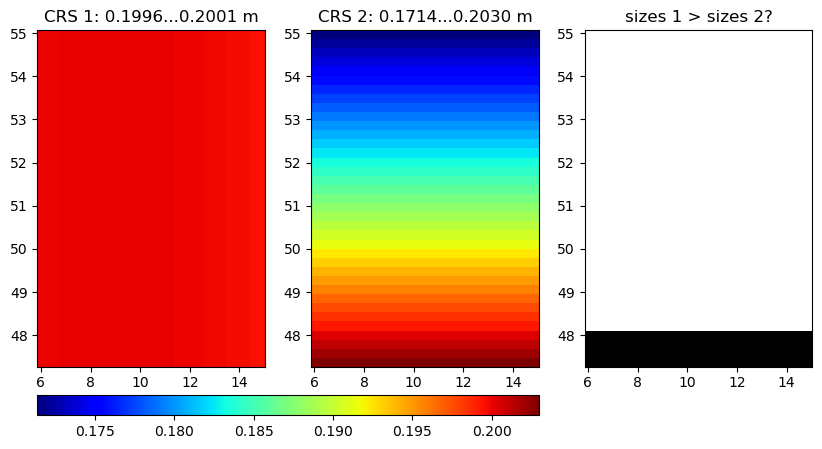

In [5]:
sizes_1 = pixel_size_in_meters(bbox, crs_1, pixel_width_1, pixel_height_1)
sizes_2 = pixel_size_in_meters(bbox, crs_2, pixel_width_2, pixel_height_2, y_samples=sizes_1.shape[0])

min_size = np.minimum(sizes_1.min(), sizes_2.min())
max_size = np.maximum(sizes_1.max(), sizes_2.max())

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(16, 3)
ax_1 = fig.add_subplot(gs[:-2, 0])
ax_2 = fig.add_subplot(gs[:-2, 1])
ax_3 = fig.add_subplot(gs[:-2, 2])
ax_cb = fig.add_subplot(gs[-1, :2])

ax_1.imshow(sizes_1, vmin=min_size, vmax=max_size, cmap='jet', origin='lower',
            extent=(bbox['l'], bbox['r'], bbox['b'], bbox['t']), aspect='auto')
aximg = ax_2.imshow(sizes_2, vmin=min_size, vmax=max_size, cmap='jet', origin='lower',
            extent=(bbox['l'], bbox['r'], bbox['b'], bbox['t']), aspect='auto')
fig.colorbar(aximg, cax=ax_cb, orientation='horizontal')

ax_3.imshow(sizes_1 > sizes_2, vmin=0, vmax=1, cmap='grey', origin='lower',
            extent=(bbox['l'], bbox['r'], bbox['b'], bbox['t']), aspect='auto')

ax_1.set_title(f'CRS 1: {sizes_1.min():.4f}...{sizes_1.max():.4f} m')
ax_2.set_title(f'CRS 2: {sizes_2.min():.4f}...{sizes_2.max():.4f} m')
ax_3.set_title(f'sizes 1 > sizes 2?')

plt.show()

The colorbar shows pixel sizes in meters from small (high resolution, blue) to large (low resolution, red). Pixel size ranges for both CRS are given in the plot titles.